The data is available as two attached CSV files:
takehome_user_engagement. csv
takehome_users . csv
The data has the following two tables:
1] A user table ( "takehome_users" ) with data on 12,000 users who signed up for the
product in the last two years. This table includes:
● name: the user's name
● object_id: the user's id
● email: email address
● creation_source: how their account was created. This takes on one
of 5 values:
○ PERSONAL_PROJECTS: invited to join another user's
personal workspace
○ GUEST_INVITE: invited to an organization as a guest
(limited permissions)
○ ORG_INVITE: invited to an organization (as a full member)
○ SIGNUP: signed up via the website
○ SIGNUP_GOOGLE_AUTH: signed up using Google
Authentication (using a Google email account for their login
id)

● creation_time: when they created their account
● last_session_creation_time: unix timestamp of last login
● opted_in_to_mailing_list: whether they have opted into receiving
marketing emails
● enabled_for_marketing_drip: whether they are on the regular
marketing email drip
● org_id: the organization (group of users) they belong to
● invited_by_user_id: which user invited them to join (if applicable).
2] A usage summary table ( "takehome_user_engagement" ) that has a row for each day
that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one seven­day period , identify which factors predict future user
adoption .
We suggest spending 1­2 hours on this, but you're welcome to spend more or less.
Please send us a brief writeup of your findings (the more concise, the better ­­ no more
than one page), along with any summary tables, graphs, code, or queries that can help
us understand your approach. Please note any factors you considered or investigation
you did, even if they did not pan out. Feel free to identify any further research or data
you think would be valuable.

In [ ]:
import pandas as pd
import numpy as np

users = pd.read_csv('takehome_users.csv', encoding='latin-1',parse_dates=True)
engage = pd.read_csv('takehome_user_engagement.csv', parse_dates=True)

In [ ]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [ ]:
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1.0,1.0
1,2013-11-15 03:45:04,2.0,1.0
2,2013-11-29 03:45:04,2.0,1.0
3,2013-12-09 03:45:04,2.0,1.0
4,2013-12-25 03:45:04,2.0,1.0


In [ ]:
import datetime

#set the time_stamp to datetime and the set it as the index
engage.time_stamp = pd.to_datetime(engage.time_stamp)
engage = engage.set_index('time_stamp', drop= True)

In [ ]:
from datetime import timedelta

def label_adopted(x):    
    "takes a users input and returns whether or not they have been active within any 7-day period"
    df_temp = engage.loc[engage['user_id'] == x] #select out rows of this user
    df_temp = df_temp.resample('D').mean().dropna() #resample to show if active in a day. .mean() is just of 1
    adopted = 0
    for i in range(len(df_temp)-2): #loop over active days till the second to last day
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [ ]:
#apply to user df to label users as adopted=true 
users['adopted_user'] = users['object_id'].apply(label_adopted)

In [ ]:
print(sum(users['adopted_user']))
print(sum(users.adopted_user)/len(users.adopted_user))

593
0.049416666666666664


**So it appears that there are only 593 active users in the dataframe, about 14% of the total users. Keeping this in mind later since it means that the classes will need to be balanced later for analysis.**

In [ ]:
# set creation_time
users.creation_time = pd.to_datetime(users.creation_time)
#last_session_creation_time is a unix time stamp, so use map to convert to datetime
users['last_session_creation_time'] = users['last_session_creation_time'].map(lambda data: 
                                    datetime.datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),
                                                                              na_action='ignore')

In [ ]:
#now set that to datetime
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'])
#subtract to find time active
users['usage_length'] = users['last_session_creation_time'] - users['creation_time']
#lets settle for seconds instead of days to make the time differences more distinct
users['usage_length'] = [x.total_seconds() for x in users['usage_length']]

In [ ]:
users['email_provider'] = [x.split('@')[1] for x in users.email]#select out the domain
top_emails = users.email_provider.value_counts().index[:6]
#label anything not in the top 5 as other
users['email_provider'] = [x if x in top_emails else 'other' for x in users.email_provider]

In [ ]:
users.invited_by_user_id = users.invited_by_user_id.fillna(0)

In [ ]:
feature_df = users.iloc[:,4:]
feature_df = feature_df.drop('last_session_creation_time', axis=1)
feature_df['usage_length'] = feature_df['usage_length'].fillna(0)

In [ ]:
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
creation_labels = gle.fit_transform(users['creation_source'])
feature_df.creation_source = creation_labels

org_id_labels = gle.fit_transform(users['org_id'])
feature_df.org_id = org_id_labels

invited_labels = gle.fit_transform(users['invited_by_user_id'])
feature_df.org_id = invited_labels

email_labels = gle.fit_transform(users['email_provider'])
feature_df.email_provider = email_labels

In [ ]:
feature_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,usage_length,email_provider
0,0,1,0,2325,10803.0,0,0.0,6
1,1,0,0,56,316.0,1,11750400.0,2
2,1,0,0,298,1525.0,0,0.0,2
3,0,0,0,1104,5151.0,0,86400.0,6
4,0,0,0,1127,5240.0,0,432000.0,6


Ananlysis

In [ ]:
from sklearn.model_selection import train_test_split

#set up data by seperating out the labels, then split for cross validation
data = feature_df.drop('adopted_user', axis=1)
labels = feature_df.adopted_user

X_train, y_train, X_test, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#train and test classifier
rf = RandomForestClassifier(class_weight='balanced_subsample')

rf.fit(X_train, X_test)

rf.score(y_train, y_test)

0.9416666666666667

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

#print out classification report and confusion matrix
y_pred = rf.predict(y_train)

print(classification_report(y_test, y_pred))

cm= confusion_matrix(y_test,y_pred)
print('confusion matrix:')
print(cm)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3760
           1       0.35      0.18      0.24       200

    accuracy                           0.94      3960
   macro avg       0.65      0.58      0.60      3960
weighted avg       0.93      0.94      0.93      3960

confusion matrix:
[[3693   67]
 [ 164   36]]


In [ ]:
#make a df that displays the cofficients indexed by feature name
feature_importance = pd.DataFrame()
feature_importance['coef'] = rf.feature_importances_
feature_importance = feature_importance.set_index(data.columns)
feature_importance.coef.nlargest(10)

usage_length                  0.837149
invited_by_user_id            0.050715
org_id                        0.050215
email_provider                0.029896
creation_source               0.016599
opted_in_to_mailing_list      0.008673
enabled_for_marketing_drip    0.006753
Name: coef, dtype: float64

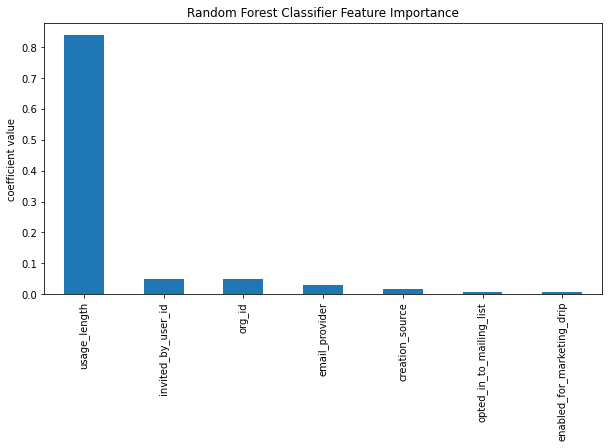

In [ ]:
#plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
(feature_importance['coef']).nlargest(10).plot(kind='bar', x=feature_importance.index)
plt.title('Random Forest Classifier Feature Importance')
plt.ylabel('coefficient value')
plt.show()

In [ ]:
#define func to find ecdf of dataset
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [ ]:
adopted = feature_df.usage_length.loc[feature_df['adopted_user'] == 1]
not_adopted = feature_df.usage_length.loc[feature_df['adopted_user'] == 0]

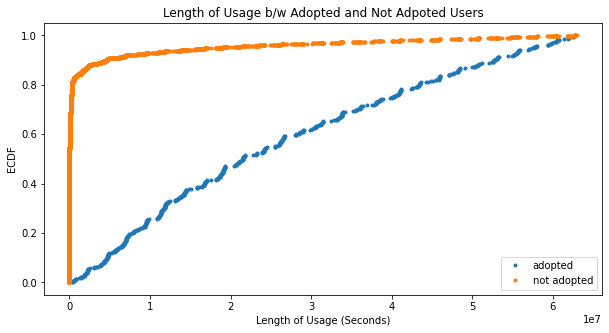

In [ ]:
#set fig size
%matplotlib inline
plt.figure(figsize=(10,5))

x_active, y_active = ecdf(adopted)
x_inactive, y_inactive = ecdf(not_adopted)

plt.plot(x_active, y_active, marker='.', linestyle='none')
plt.plot(x_inactive, y_inactive, marker='.', linestyle='none')
plt.title('Length of Usage b/w Adopted and Not Adpoted Users')
plt.xlabel('Length of Usage (Seconds)')
plt.ylabel('ECDF')
plt.legend(['adopted', 'not adopted'])
plt.show()

Here it is apparent that at the maxium time usage of non-adopted users, approximately 60% of the active users have usage above that amount of time (approximately 230 days).